## Category3.취약계층의_시설_동선확인_1_전처리

### 목차
- (1)데이터 전처리
    - 1 연령별 유동인구와 상주인구
        - 1-1 유동인구 500m 이내
        - 1-2 상주인구 500m 이내
    - 2 영유아 시설
        - 2-1 영유아시설 정류소 500m 이내 정원합
    - 3 고령층 시설
        - 3-1 고령층 시설 정류소 500m 이내 정원합
    - 4 임산부 유동지수
        - 4-1 임산부를 위한 산부인과 정류소 500m 이내 
    - 5 관련 변수 모두 결합
- (2) 군집화


In [ ]:
from geoband.API import *
GetCompasData('SBJ_2102_002', '1', '1.수원시_버스정류장.csv')
GetCompasData('SBJ_2102_002', '15', '15.수원시_성연령별_유동인구(2020).csv')
GetCompasData('SBJ_2102_002', '17', '17.수원시_인구정보(고령)_격자.geojson')
GetCompasData('SBJ_2102_002', '19', '19.수원시_인구정보(유소년)_격자.geojson')

In [ ]:
import numpy as np
import json
import pandas as pd
import geopandas as gpd
import fiona
import pyproj  # 좌표계 정의/변환용 라이브러리
from fiona.crs import from_epsg
import urllib
import urllib.request


/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## (1)1. 연령별 유동인구와 상주인구

In [ ]:
d1=pd.read_csv('15.수원시_성연령별_유동인구(2020).csv')

d1060=d1.groupby(by=['lon','lat'])['MAN_FLOW_POP_CNT_60GU','WMAN_FLOW_POP_CNT_60GU'].sum()

d1060s=d1060.apply(sum,axis=1)

lon=[i[0] for i in d1060.index]
lat=[i[1] for i in d1060.index]

bus=pd.read_csv('1.수원시_버스정류장.csv')
bus=bus.loc[bus.BIS설치여부==1,['정류장ID','정류장명','lon','lat']]


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


버스정류소 좌표 array 로 만들기

In [ ]:
bus_array = bus[['정류장ID','lon','lat']]
bus_array['정류장ID'] = bus_array['정류장ID'].astype(str)
bus_array = bus_array[['정류장ID','lon','lat']].to_numpy()
bus_array

d1060s=pd.DataFrame(d1060s)

d1060s['lon']=[i[0] for i in d1060s.index]
d1060s['lat']=[i[1] for i in d1060s.index]

d1060s.reset_index(inplace=True,drop=True)
d1060s=d1060s.rename({0:'floatpop'},axis='columns')

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


유동인구 비율(취약/전체)

In [ ]:
float_tot=d1.iloc[:,1:15].groupby(by=['lon','lat']).sum().apply(sum,axis=1)
float_YO=d1.groupby(by=['lon','lat'])['MAN_FLOW_POP_CNT_10G','MAN_FLOW_POP_CNT_60GU','WMAN_FLOW_POP_CNT_10G','WMAN_FLOW_POP_CNT_60GU'].sum().apply(sum,axis=1)

d1060_ratio=pd.DataFrame(float_YO/float_tot)
d1060_ratio['lon']=[i[0] for i in d1060_ratio.index]
d1060_ratio['lat']=[i[1] for i in d1060_ratio.index]

d1060_ratio.reset_index(inplace=True,drop=True)
d1060_ratio=d1060_ratio.rename({0:'floatpop'},axis='columns')

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


### 1-1. 유동인구 500m이내

유동인구 좌표 array 로 만들기

In [ ]:
float_array = d1060s[['floatpop','lon','lat']]
float_array = float_array.to_numpy()
float_array

array([[2.00000000e-02, 1.26927348e+02, 3.72787028e+01],
       [1.03100000e+01, 1.26927389e+02, 3.72732946e+01],
       [6.05000000e+00, 1.26927392e+02, 3.72728440e+01],
       ...,
       [8.76700000e+01, 1.27089129e+02, 3.72951492e+01],
       [9.47000000e+00, 1.27089134e+02, 3.72942478e+01],
       [1.67000000e+00, 1.27089136e+02, 3.72937972e+01]])

### Harversine공식을 이용해서 반경 500m 구하기

In [ ]:
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

In [ ]:
float_500m=[] 
for i in range(bus_array.shape[0]):
    each_float=0
    for j in range(float_array.shape[0]):
        h_dis = GeoUtil.get_harversion_distance(bus_array[i,1], bus_array[i,2], float_array[j,1],float_array[j,2])
        if h_dis<=0.5:  
            each_float+=float_array[j,0]
            
    float_500m.append(each_float)

float_bus=pd.DataFrame({'float':float_500m})

### 1-2. 상주인구 500m 이내로 변경

In [ ]:
old=gpd.read_file('17.수원시_인구정보(고령)_격자.geojson')
young=gpd.read_file('19.수원시_인구정보(유소년)_격자.geojson')
old.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       12500 non-null  object  
 1   val       4499 non-null   float64 
 2   geometry  12500 non-null  geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 293.1+ KB


In [ ]:
young.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       12500 non-null  object  
 1   val       3848 non-null   float64 
 2   geometry  12500 non-null  geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 293.1+ KB


필요한 feature 데이터프레임으로 묶기

In [ ]:
old_df=pd.DataFrame(old[['gid','val']])
young_df=pd.DataFrame(young[['gid','val']])

#### 격자별 중심점 기준으로, 거주인구 50,50, 격자 단위

In [ ]:
old_df['lon']=old.centroid.x
old_df['lat']=old.centroid.y

young_df['lon']=young.centroid.x
young_df['lat']=young.centroid.y

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely inc

In [ ]:
oldyoung=pd.merge(old_df,young_df,how='outer',on='gid')

oldyoung['weak']=oldyoung['val_x']+oldyoung['val_y']

In [ ]:
oldyoung=oldyoung[['gid','lon_y', 'lat_y', 'weak']]
oldyoung.columns=['gid','lon','lat','weak']
oldyoung=oldyoung[oldyoung.weak.notnull()]
oldyoung.head(3)

,gid,lon,lat,weak
146,다사497196,126.933200,37.274412,79.0
147,다사497197,126.933194,37.275313,259.0
148,다사497198,126.933187,37.276215,85.0


In [ ]:
weak_array=oldyoung[['weak','lon','lat']]
weak_array=weak_array.to_numpy()
weak_array

array([[ 79.        , 126.93320049,  37.27441196],
       [259.        , 126.93319374,  37.27531332],
       [ 85.        , 126.93318698,  37.27621467],
       ...,
       [ 99.        , 127.085352  ,  37.29667611],
       [ 81.        , 127.0864852 ,  37.29577868],
       [ 86.        , 127.08648027,  37.29668006]])

#### 정류소별 500m 이내 인구 합 구하기

In [ ]:
weak_500m=[] 
for i in range(bus_array.shape[0]):
    each_weak=0
    for j in range(weak_array.shape[0]):
        h_dis = GeoUtil.get_harversion_distance(bus_array[i,1], bus_array[i,2], weak_array[j,1],weak_array[j,2])
        if h_dis<=0.5:  
            each_weak+=weak_array[j,0]
            
    weak_500m.append(each_weak) 

live_bus=pd.DataFrame({'live':weak_500m})

In [ ]:
bus.reset_index(inplace=True,drop=True)
bus.insert(2,'live',live_bus)
bus.insert(3,'float',float_bus)
bus.head(5)

,정류장ID,정류장명,live,float,lon,lat
0,201000313,권선구청,0.0,77917.62,126.970983,37.256983
1,201000345,남수원초등학교,3897.0,201789.65,127.016000,37.251091
2,201000379,신미주아파트,5048.0,116183.23,126.953845,37.268806
3,201000055,농수산물시장,3237.0,113171.60,127.029815,37.256755
4,201000268,곡반중학교,3317.0,186576.57,127.034254,37.246081


In [ ]:
bus.to_csv('data/상주유동500m.csv',index=False)

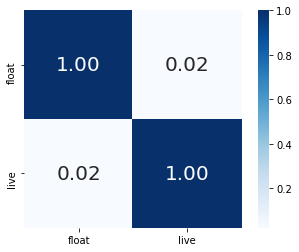

In [ ]:
#변수별 상관계수
import seaborn as sns
corr = bus[['float','live']].corr(method='pearson')
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

### 취약계층 유동인구와 거주인구 사이의 큰 괴리가 보임

* 유동인구 지표로는 10대와 60대를 사용했는데  
  거주인구 지표로는 유소년(초등까지), 고령을 사용해서  
  중학생~ 고등학생 사이의 연령 인원으로 인한 차이로 해석됨.  

* 따라서 정확한 측정이 불가능한 유동인구 변수를 제외하고  
  취약계층 관련 인프라를 단순 개수로가 아닌 인프라의 정원까지 고려하여 유동지수를 만들어서 추가적으로 고려할 필요성.


## (1) 2 영유아 시설 

공공데이터 생애주기, 교육청 데이터 사용

초등 데이터

In [ ]:
school=pd.read_excel('data/20년 하반기(10.1) 유초중등 학교별 학년별 학생수 학급수 교원 직원_210219.xlsx')

element=school.loc[(school['Unnamed: 2']=='수원시')&(school['Unnamed: 4']=='초등학교'),['Unnamed: 8','Unnamed: 18','Unnamed: 29']]
element.columns=['명칭','소재지도로명주소','정원수']
element.reset_index(inplace=True,drop=True)

element.head(3)

,명칭,소재지도로명주소,정원수
0,광교초등학교,경기도 수원시 영통구 대학로 91 (이의동),1188
1,이의초등학교,경기도 수원시 영통구 법조로 150 . 47 (하동),1151
2,선행초등학교,경기도 수원시 권선구 세권로196번길 21 (권선동. 선행초등학교),708


유치원 데이터

In [ ]:
kinder=school.loc[(school['Unnamed: 2']=='수원시')&(school['Unnamed: 4']=='유치원'),['Unnamed: 8','Unnamed: 18','Unnamed: 29']]
kinder.columns=['명칭','소재지도로명주소','정원수']
kinder.reset_index(inplace=True,drop=True)

kinder.head(3)

,명칭,소재지도로명주소,정원수
0,광교초등학교병설유치원,경기도 수원시 영통구 대학로 91 . 광교초등학교 (이의동. 광교초등학교병설유치원),25
1,곡정초등학교병설유치원,경기도 수원시 권선구 곡선로 7 (권선동. 곡정초등학교),47
2,능실초등학교병설유치원,경기도 수원시 권선구 호매실로165번길 28 . 능실초등학교병설유치원 (호매실동),31


어린이집 데이터

In [ ]:
Daycare=pd.read_csv('data/어린이집현황(개방표준).csv',encoding='cp949')
Daycare=Daycare.loc[Daycare.시군구명=='수원시',['어린이집명','소재지도로명주소','정원수']]
Daycare.reset_index(inplace=True,drop=True)

Daycare.head(3)

,어린이집명,소재지도로명주소,정원수
0,나나어린이집,경기도 수원시 장안구 만석로159번길 38-5,34
1,네버랜드어린이집,경기도 수원시 장안구 일월로66번길 15 (천천동),79
2,노틀담어린이집,경기도 수원시 장안구 덕영대로407번길 83 서희스타힐스 103동 103호,19


### 네이버 api 주소 -> 위경도

In [ ]:
def geocoding_NaverApi(addr):
    ClientID='azxbhbvbvs'
    ClientSecret='2aCnmWXiSpF4V1mbFIcM623lIT0elhGNZugOZlam'
    query_content=urllib.parse.quote(addr)
    url='https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query='+query_content
    request= urllib.request.Request(url)
    request.add_header('X-NCP-APIGW-API-KEY-ID', ClientID)
    request.add_header('X-NCP-APIGW-API-KEY', ClientSecret)
    response = urllib.request.urlopen(request)
    #요청 상태 확인
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        contents=json.loads(response_body.decode('utf-8'))
        return contents['addresses']
    else:
        print("Error Code:" + rescode)

In [ ]:
addr_element=element['소재지도로명주소']
addr_kinder=kinder['소재지도로명주소']
addr_Daycare=Daycare['소재지도로명주소']

위경도 변환 & 변환 안된 데이터 주소 살펴보기

In [ ]:
lonlat_element=np.array([geocoding_NaverApi(i) for i in addr_element])
lonlat_kinder=np.array([geocoding_NaverApi(i) for i in addr_kinder])
lonlat_Daycare=np.array([geocoding_NaverApi(i) for i in addr_Daycare])

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

오류나는 부분 설정

In [ ]:
bool_idx=[len(i)==0 for i in lonlat_element]
addr_element[bool_idx]
addr_element[bool_idx]=['경기도 수원시 영통구 법조로150번길 47 이의초등학교','경기도 수원시 권선구 곡선로 7 곡정초등학교']

bool_idx=[len(i)==0 for i in lonlat_kinder]
addr_kinder[bool_idx]
addr_kinder[bool_idx]=['경기도 수원시 권선구 금곡로31번길 92 상촌초등학교']

bool_idx=[len(i)==0 for i in lonlat_Daycare]
addr_Daycare[bool_idx]
                        
import re
fix_doc=[re.findall('[가-힣]*로[ ][1-9]+',i) for i in Daycare[bool_idx].소재지도로명주소]
fix_doc=pd.Series(fix_doc)
fix_doc[5]=['고화로18번길 15-3']
fix_doc[10]=['경기도 수원시 권선구 오목천동 473-3']
[i[0] for i in fix_doc]

addr_Daycare[bool_idx]=[i[0] for i in fix_doc]

lonlat_element=np.array([geocoding_NaverApi(i) for i in addr_element])
lonlat_kinder=np.array([geocoding_NaverApi(i) for i in addr_kinder])
lonlat_Daycare=np.array([geocoding_NaverApi(i) for i in addr_Daycare])

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


초등, 유치원, 어린이집 위도 경도 추출하기

In [ ]:
element_xy=[[i[0]['x'],i[0]['y']] for i in lonlat_element]
element['lon']=[i[0] for i in element_xy]
element['lat']=[i[1] for i in element_xy]

In [ ]:
kinder_xy=[[i[0]['x'],i[0]['y']] for i in lonlat_kinder]
kinder['lon']=[i[0] for i in kinder_xy]
kinder['lat']=[i[1] for i in kinder_xy]

In [ ]:
Daycare_xy=[[i[0]['x'],i[0]['y']] for i in lonlat_Daycare]
Daycare['lon']=[i[0] for i in Daycare_xy]
Daycare['lat']=[i[1] for i in Daycare_xy]
Daycare.rename(columns={'어린이집명':'명칭'},inplace=True)

데이터 결합

In [ ]:
school_data=pd.DataFrame()

school_data=school_data.append(element)
school_data=school_data.append(kinder)
school_data=school_data.append(Daycare)
school_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1424 entries, 0 to 1135
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   명칭        1424 non-null   object
 1   소재지도로명주소  1424 non-null   object
 2   정원수       1424 non-null   object
 3   lon       1424 non-null   object
 4   lat       1424 non-null   object
dtypes: object(5)
memory usage: 66.8+ KB


### 2-1 영유아시설 정류소 500m 이내 정원합
- harversine 공식 이용

버스정류소 좌표 array로 만들기

In [ ]:
bus=pd.read_csv('1.수원시_버스정류장.csv')
bus=bus.loc[bus.BIS설치여부==1,['정류장ID','정류장명','lon','lat']]

bus_array = bus[['정류장ID','lon','lat']]
bus_array['정류장ID'] = bus_array['정류장ID'].astype(str)
bus_array = bus_array[['정류장ID','lon','lat']].to_numpy()
bus_array

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([['201000313', 126.9709828, 37.25698318],
       ['201000345', 127.0160003, 37.25109066],
       ['201000379', 126.9538449, 37.26880555],
       ...,
       ['202000246', 126.98171380000001, 37.28799446],
       ['202000239', 126.98607630000001, 37.28666265],
       ['202000238', 126.9850962, 37.28950644]], dtype=object)

영유아시설좌표 array로 만들기

In [ ]:
school_array=school_data[['정원수','lon','lat']].astype('float').to_numpy()
school_array

array([[1188.       ,  127.0461046,   37.3037745],
       [1151.       ,  127.0756088,   37.2930758],
       [ 708.       ,  127.0261005,   37.25441  ],
       ...,
       [ 160.       ,  127.014896 ,   37.2558434],
       [  19.       ,  126.9523783,   37.2681696],
       [  17.       ,  127.0435363,   37.2554072]])

영유아 시설 500m 기준 harversine 이용하기

In [ ]:
school_500m=[] 
for i in range(bus_array.shape[0]):
    each_school=0
    for j in range(school_array.shape[0]):
        h_dis = GeoUtil.get_harversion_distance(bus_array[i,1], bus_array[i,2], school_array[j,1],school_array[j,2])
        if h_dis<=0.5:  
            each_school+=school_array[j,0]
            
    school_500m.append(each_school) 

In [ ]:
bus.insert(2,'영유아정원합',school_500m)
bus1=bus
bus1

,정류장ID,정류장명,영유아정원합,lon,lat
0,201000313,권선구청,181.0,126.970983,37.256983
2,201000345,남수원초등학교,1201.0,127.016000,37.251091
3,201000379,신미주아파트,4227.0,126.953845,37.268806
4,201000055,농수산물시장,2053.0,127.029815,37.256755
5,201000268,곡반중학교,1773.0,127.034254,37.246081
...,...,...,...,...,...
1107,202000249,화서오거리,1523.0,126.999697,37.278865
1108,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,1802.0,126.995823,37.284316
1109,202000246,엘지아파트.금강아파트,2416.0,126.981714,37.287994
1110,202000239,꽃뫼신동아아파트,977.0,126.986076,37.286663


## (1) 3 고령층 시설

In [ ]:
area = gpd.read_file("29.수원시_법정경계(시군구).geojson") 
area.head()

,SIG_CD,SIG_KOR_NM,geometry
0,41111,수원시 장안구,"MULTIPOLYGON (((127.01976 37.35104, 127.02008 ..."
1,41113,수원시 권선구,"MULTIPOLYGON (((127.03723 37.23684, 127.03679 ..."
2,41115,수원시 팔달구,"MULTIPOLYGON (((127.03582 37.29361, 127.03644 ..."
3,41117,수원시 영통구,"MULTIPOLYGON (((127.07484 37.26588, 127.07488 ..."


In [ ]:
dong=gpd.read_file('31.수원시_행정경계(읍면동).geojson')
dong.head()

,ADM_DR_CD,ADM_DR_NM,geometry
0,3101154,파장동,"MULTIPOLYGON (((127.00491 37.33910, 127.00535 ..."
1,3101155,율천동,"MULTIPOLYGON (((126.97444 37.30857, 126.97466 ..."
2,3101156,정자1동,"MULTIPOLYGON (((126.98764 37.31051, 126.98754 ..."
3,3101157,정자2동,"MULTIPOLYGON (((126.99806 37.29766, 126.99830 ..."
4,3101159,송죽동,"MULTIPOLYGON (((127.01135 37.31892, 127.01146 ..."


### 버스정류장

In [ ]:
bus=pd.read_csv('1.수원시_버스정류장.csv')

버스정류소 위치(동)만 추출

In [ ]:
bus['dong'] = bus['위치(동)'].str.split(" ").str[2]

태장동 -> 망포1,2동으로 변경

In [ ]:
bus['dong'] =bus.apply(lambda x: '망포1.2동' if (x.dong=='태장동') else x.dong,axis=1)

버스정류소 사용할 변수 추출

In [ ]:
bus=bus.loc[bus.BIS설치여부==1,['정류장ID','정류장명','dong','lon','lat']]
bus.head()

,정류장ID,정류장명,dong,lon,lat
0,201000313,권선구청,서둔동,126.970983,37.256983
2,201000345,남수원초등학교,세류2동,127.016000,37.251091
3,201000379,신미주아파트,금곡동,126.953845,37.268806
4,201000055,농수산물시장,권선1동,127.029815,37.256755
5,201000268,곡반중학교,곡선동,127.034254,37.246081


### 노약자

[https://data.gg.go.kr/portal/adjust/lifeDataPage.do]
- 경기 데이터드림 출처

In [ ]:
d1=pd.read_csv('data/경기도_노인의료복지시설현황.csv', encoding='EUC-KR')
d2=pd.read_csv('data/경로당현황_인허가.csv', encoding='EUC-KR')
d3=pd.read_csv('data/노인교실현황.csv', encoding='EUC-KR')
d4=pd.read_csv('data/노인요양시설현황.csv', encoding='EUC-KR')

In [ ]:
d1['시군구명'] = d1['시군구명'].str.split(" ").str[0]
d1 = d1[['시군구명','시설명','지번 주소','입소정원','WGS84위도','WGS84경도']]
d1.columns = ['시군명','시설명','지번주소','입소정원','lat','lon']

d2 = d2[['시군명','사업장명','입소정원(명)','소재지지번주소','WGS84위도','WGS84경도']]
d2.columns = ['시군명','시설명','입소정원','지번주소','lat','lon']


d3 = d3[['시군명','사업장명','입소정원(명)','소재지지번주소','WGS84위도','WGS84경도']]
d3.columns = ['시군명','시설명','입소정원','지번주소','lat','lon']

d4 = d4[['시군명','사업장명','입소정원(명)','소재지지번주소','WGS84위도','WGS84경도']]
d4.columns = ['시군명','시설명','입소정원','지번주소','lat','lon']

4개 데이터 합치고 dong feature 생성

In [ ]:
d = pd.concat([d1,d2,d3,d4], ignore_index=True)
d['dong'] = d['지번주소'].str.split(" ").str[3]

In [ ]:
d = d.dropna(axis=0)  # 입소정원 = 1
d = d[d.입소정원>0]  # 211명
d

,시군명,시설명,지번주소,입소정원,lat,lon,dong
0,수원시,가람실버밸리요양원,경기도 수원시 권선구 권선동 1053-7번지,27.0,37.256771,127.025979,권선동
1,수원시,고색요양원,경기도 수원시 권선구 고색동 204-1번지,26.0,37.251736,126.993143,고색동
2,수원시,늘봄실버벨리,경기도 수원시 권선구 권선동 945-1번지,35.0,37.263043,127.022892,권선동
3,수원시,다사랑노인복지요양원,경기도 수원시 권선구 호매실동 415-6번지,49.0,37.266261,126.956457,호매실동
4,수원시,미소1요양원,경기도 수원시 권선구 탑동 835-4번지,9.0,37.268844,126.974449,탑동
...,...,...,...,...,...,...,...
239,수원시,"대우,동신",경기도 수원시 영통구 영통동 956-2번지,27.0,37.259436,127.076660,영통동
240,수원시,대한노인회 영통구지구 부설 노인교실,경기도 수원시 영통구 영통동 958-2번지,150.0,37.255463,127.074246,영통동
241,수원시,사회복지법인 죽파재단 감천장요양원,경기도 수원시 장안구 영화동,90.0,37.294003,127.014216,영화동
242,수원시,효행노인전문요양원,경기도 수원시 장안구 조원동,100.0,37.296211,127.011724,조원동


In [ ]:
d.to_csv('data/노인시설_정원.csv',index=False)

### 3-1 고령층 시설 정류소 500m 이내 정원합

In [ ]:
oldcenter_array=pd.read_csv('data/노인시설_정원.csv')[['입소정원','lon','lat']].to_numpy()
oldcenter_array

array([[ 27.        , 127.025979  ,  37.25677119],
       [ 26.        , 126.9931433 ,  37.25173628],
       [ 35.        , 127.022892  ,  37.26304292],
       [ 49.        , 126.9564567 ,  37.26626119],
       [  9.        , 126.9744486 ,  37.26884382],
       [  9.        , 126.9744486 ,  37.26884382],
       [  9.        , 126.9408449 ,  37.29076197],
       [  7.        , 126.9776713 ,  37.27396239],
       [ 29.        , 127.0115277 ,  37.25573694],
       [  9.        , 126.9737811 ,  37.27487154],
       [  9.        , 126.9563674 ,  37.24632135],
       [  9.        , 126.9563674 ,  37.24632135],
       [  9.        , 126.9939203 ,  37.25851209],
       [ 47.        , 126.986752  ,  37.25309614],
       [  7.        , 126.9737811 ,  37.27487154],
       [ 14.        , 127.0260577 ,  37.25593322],
       [ 40.        , 126.9905057 ,  37.25193426],
       [ 83.        , 127.0303114 ,  37.23627179],
       [ 99.        , 127.0227785 ,  37.25985329],
       [ 29.        , 126.9429 

In [ ]:
old_500m=[] 
for i in range(bus_array.shape[0]):
    each_old=0
    for j in range(oldcenter_array.shape[0]):
        h_dis = GeoUtil.get_harversion_distance(bus_array[i,1], bus_array[i,2], oldcenter_array[j,1],oldcenter_array[j,2])
        if h_dis<=0.5:  
            each_old+=oldcenter_array[j,0]
            
    old_500m.append(each_old) 

영유아정원합에 노령정원합 합치기

In [ ]:
bus1.insert(2,'노령정원합',old_500m)
bus1.head(4)

,정류장ID,정류장명,노령정원합,영유아정원합,lon,lat
0,201000313,권선구청,0.0,181.0,126.970983,37.256983
2,201000345,남수원초등학교,52.0,1201.0,127.016000,37.251091
3,201000379,신미주아파트,104.0,4227.0,126.953845,37.268806
4,201000055,농수산물시장,58.0,2053.0,127.029815,37.256755


In [ ]:
bus1.to_csv('data/500영유아_노령.csv',index=False)

## (1) 4 임산부 유동지수

*  버스정류소별 500m 이내 산부인과 진료 의사수 총합
*  데이터 : 공공데이터 생애주기 카테고리 출처
*  산부인과가 수용할 수 있는 임산부의 정원에 관련된 데이터를 찾을 수 없어 산부인과의 의료인수(명)로 대체함

In [ ]:
d1=pd.read_csv('data/병원급산부인과현황.csv',encoding='cp949')
d1=d1.loc[(d1['시군명']=='수원시')&(d1['영업상태명']=='운영중'),['의료인수(명)','WGS84경도','WGS84위도']]
d1.reset_index(inplace=True,drop=True)
d1.head(10)

,의료인수(명),WGS84경도,WGS84위도
0,37,127.022778,37.259853
1,70,127.028803,37.273818
2,18,127.027507,37.276738
3,94,127.076577,37.252660
4,4,127.080525,37.267182
5,68,127.033945,37.249264
6,31,126.953903,37.275379
7,35,127.075587,37.254931
8,32,127.080964,37.266596
9,35,127.006423,37.291986


In [ ]:
d2=pd.read_csv('data/부인과한방병원현황.csv',encoding='cp949')
d2=d2.loc[(d2['시군명']=='수원시')&(d2['영업상태명']=='운영중'),['의료인수(명)','WGS84경도','WGS84위도']]
d2.reset_index(inplace=True,drop=True)
d2.head(3)

,의료인수(명),WGS84경도,WGS84위도
0,27,127.072329,37.253327
1,31,127.033280,37.278644


In [ ]:
d3=pd.read_csv('data/의원급산부인과현황.csv',encoding='cp949')
d3=d3.loc[(d3['시군명']=='수원시')&(d3['영업상태명']=='운영중'),['의료인수(명)','WGS84경도','WGS84위도']]
d3.reset_index(inplace=True,drop=True)
d3.head(3)

,의료인수(명),WGS84경도,WGS84위도
0,1,126.974522,37.268888
1,1,126.941990,37.273976
2,1,127.047617,37.272984


의료진 수 없어서 직접 검색

In [ ]:
d4=pd.read_csv('data/전문병원급산부인과현황.csv',encoding='cp949')
d4=d4[3:4][['WGS84위도','WGS84경도']]

시온병원 홈페이지 검색 의료진 21명

In [ ]:
d4.insert(0,'의료인수(명)',21)
d4.reset_index(inplace=True,drop=True)
d4.head(3)

,의료인수(명),WGS84위도,WGS84경도
0,21,37.25266,127.076576


모든 산부인과 의료진 데이터 결합

In [ ]:
freg=pd.concat([d1,d2,d3,d4]).reset_index(drop=True)
freg.head(3)

,의료인수(명),WGS84경도,WGS84위도
0,37,127.022778,37.259853
1,70,127.028803,37.273818
2,18,127.027507,37.276738


### 4-1 임산부를 위한 산부인과 정류소 500m 이내 

산부인과 array 만들기산부인과 array 만들기

In [ ]:
freg_array=freg.to_numpy()
freg_array

array([[ 37.        , 127.02277847,  37.25985329],
       [ 70.        , 127.02880293,  37.27381808],
       [ 18.        , 127.02750727,  37.27673768],
       [ 94.        , 127.07657653,  37.25265983],
       [  4.        , 127.08052527,  37.26718191],
       [ 68.        , 127.03394547,  37.24926378],
       [ 31.        , 126.95390288,  37.27537857],
       [ 35.        , 127.0755868 ,  37.25493104],
       [ 32.        , 127.08096434,  37.26659595],
       [ 35.        , 127.00642314,  37.29198556],
       [ 18.        , 126.97614597,  37.251157  ],
       [ 27.        , 127.07232866,  37.25332675],
       [ 31.        , 127.03328012,  37.27864366],
       [  1.        , 126.9745219 ,  37.26888773],
       [  1.        , 126.94199047,  37.27397594],
       [  1.        , 127.04761725,  37.27298448],
       [  2.        , 127.07344805,  37.25278995],
       [  1.        , 126.99272669,  37.30739338],
       [  2.        , 127.01701615,  37.27832603],
       [  1.        , 126.96600

harversine 공식 이용하기

In [ ]:
bus=pd.read_csv('1.수원시_버스정류장.csv')
bus=bus.loc[bus.BIS설치여부==1,['정류장ID','정류장명','lon','lat']]

bus_array = bus[['정류장ID','lon','lat']]
bus_array['정류장ID'] = bus_array['정류장ID'].astype(str)
bus_array = bus_array[['정류장ID','lon','lat']].to_numpy()
bus_array

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


array([['201000313', 126.9709828, 37.25698318],
       ['201000345', 127.0160003, 37.25109066],
       ['201000379', 126.9538449, 37.26880555],
       ...,
       ['202000246', 126.98171380000001, 37.28799446],
       ['202000239', 126.98607630000001, 37.28666265],
       ['202000238', 126.9850962, 37.28950644]], dtype=object)

In [ ]:
freg_500m=[] 
for i in range(bus_array.shape[0]):
    each_freg=0
    for j in range(freg_array.shape[0]):
        h_dis = GeoUtil.get_harversion_distance(bus_array[i,1], bus_array[i,2], freg_array[j,1],freg_array[j,2])
        if h_dis<=0.5:  
            each_freg+=freg_array[j,0]
            
    freg_500m.append(each_freg) 

## (1) 5 관련 변수 모두 결합

* 인프라지수
    * 임산부시설(산부인과)
    * 노령시설(노인교실,양로원, 요양병원)
    * 영유아시설(어린이집,유치원, 초등학교)

* 거주인구(유소년인구, 고령인구) 

In [ ]:
bus=pd.read_csv('data/500영유아_노령.csv')
bus.reset_index(inplace=True,drop=True)
bus.insert(2,'취약거주인구',pd.read_csv('data/상주유동500m.csv')['live'])
bus.insert(2,'산부인과의료진',freg_500m)
bus

,정류장ID,정류장명,산부인과의료진,취약거주인구,노령정원합,영유아정원합,lon,lat
0,201000313,권선구청,0.0,0.0,0.0,181.0,126.970983,37.256983
1,201000345,남수원초등학교,2.0,3897.0,52.0,1201.0,127.016000,37.251091
2,201000379,신미주아파트,0.0,5048.0,104.0,4227.0,126.953845,37.268806
3,201000055,농수산물시장,0.0,3237.0,58.0,2053.0,127.029815,37.256755
4,201000268,곡반중학교,68.0,3317.0,0.0,1773.0,127.034254,37.246081
...,...,...,...,...,...,...,...,...
923,202000249,화서오거리,2.0,4791.0,72.0,1523.0,126.999697,37.278865
924,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,5.0,4323.0,132.0,1802.0,126.995823,37.284316
925,202000246,엘지아파트.금강아파트,0.0,4837.0,99.0,2416.0,126.981714,37.287994
926,202000239,꽃뫼신동아아파트,5.0,2490.0,21.0,977.0,126.986076,37.286663


In [ ]:
bus.to_csv('data/category3전처리.csv',index=False)